In [89]:
import os
import pandas as pd
from xgdatatools import xgimport
from xgdatatools import xgstruct

In [90]:
def get_match_header(rec):
    print(rec)

In [91]:
def process_game_file(segment):
    fileversion = -1
    segment.fd.seek(os.SEEK_SET, 0)
    cube_list = []
    while True:
        rec = xgstruct.GameFileRecord(
            version=fileversion).fromstream(segment.fd)
        if rec is None:
            break
        if isinstance(rec, xgstruct.HeaderMatchEntry):
            fileversion = rec.Version
            get_match_header(rec)
        elif isinstance(rec, xgstruct.FooterMatchEntry):
            get_match_header(rec)
        # elif isinstance(rec, xgstruct.HeaderGameEntry):
        #     print(rec)
        elif isinstance(rec, xgstruct.CubeEntry):
            # print(rec)
            cube_list.append(rec)
    return cube_list



In [92]:
xgobj = xgimport.Import('data/Expert-Expert 2023-10-01.xg')

In [93]:
for segment in xgobj.getfilesegment():
    if segment.type == xgimport.Import.Segment.XG_GAMEFILE:
        print('game file')
        cube_list = process_game_file(segment)
    if segment.type == xgimport.Import.Segment.XG_COMMENT:
        print('comment file')
    elif segment.type == xgimport.Import.Segment.XG_ROLLOUTS:
        print('XG_ROLLOUTS')


game file
{'Name': 'MatchInfo', 'EntryType': 0, 'SPlayer1': 'Expert', 'SPlayer2': 'Expert', 'MatchLength': 99999, 'Variation': 0, 'Crawford': True, 'Jacoby': True, 'Beaver': True, 'AutoDouble': False, 'Elo1': 2201.0, 'Elo2': 2201.0, 'Exp1': 400, 'Exp2': 400, 'Date': '2023-10-01 06:53:45', 'SEvent': '', 'GameId': 750028733, 'CompLevel1': 0, 'CompLevel2': 0, 'CountForElo': False, 'AddtoProfile1': False, 'AddtoProfile2': False, 'SLocation': 'eXtreme Gammon', 'GameMode': 4, 'Imported': False, 'SRound': '', 'Invert': 1, 'Version': 30, 'Magic': 1229737284, 'MoneyInitG': 0, 'MoneyInitScore': (0, 0), 'Entered': False, 'Counted': False, 'UnratedImp': False, 'CommentHeaderMatch': -1, 'CommentFooterMatch': -1, 'isMoneyMatch': False, 'WinMoney': 0.0, 'LoseMoney': 0.0, 'Currency': 0, 'FeeMoney': 0.0, 'TableStake': 0, 'SiteId': -1, 'CubeLimit': 10, 'AutoDoubleMax': 0, 'Transcribed': False, 'Event': b'', 'Player1': b'Expert', 'Player2': b'Expert', 'Location': b'eXtreme Gammon', 'Round': b'', 'TimeSet

In [94]:
# リスト内の辞書を展開して、各辞書のキーを列名として使用してDataFrameを作成する
data = []
for cube in cube_list:
    flattened_item = {}
    for key, value in cube.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                flattened_item[f"{key}_{sub_key}"] = sub_value
        else:
            flattened_item[key] = value
    data.append(flattened_item)

df = pd.DataFrame(data)

In [95]:
df.columns

Index(['Name', 'EntryType', 'ActiveP', 'Double', 'Take', 'BeaverR', 'RaccoonR',
       'CubeB', 'Position', 'Doubled_Pos', 'Doubled_Level', 'Doubled_Score',
       'Doubled_Cube', 'Doubled_CubePos', 'Doubled_Jacoby', 'Doubled_Crawford',
       'Doubled_met', 'Doubled_FlagDouble', 'Doubled_isBeaver', 'Doubled_Eval',
       'Doubled_equB', 'Doubled_equDouble', 'Doubled_equDrop',
       'Doubled_LevelRequest', 'Doubled_DoubleChoice3', 'Doubled_EvalDouble',
       'ErrCube', 'DiceRolled', 'ErrTake', 'RolloutIndexD', 'CompChoiceD',
       'AnalyzeC', 'ErrBeaver', 'ErrRaccoon', 'AnalyzeCR', 'isValid',
       'TutorCube', 'TutorTake', 'ErrTutorCube', 'ErrTutorTake',
       'FlaggedDouble', 'CommentCube', 'EditedCube', 'TimeDelayCube',
       'TimeDelayCubeDone', 'NumberOfAutoDoubleCube', 'TimeBot', 'TimeTop',
       'Version'],
      dtype='object')

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12474 entries, 0 to 12473
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    12474 non-null  object 
 1   EntryType               12474 non-null  int64  
 2   ActiveP                 12474 non-null  int64  
 3   Double                  12474 non-null  int64  
 4   Take                    12474 non-null  int64  
 5   BeaverR                 12474 non-null  int64  
 6   RaccoonR                12474 non-null  int64  
 7   CubeB                   12474 non-null  int64  
 8   Position                12474 non-null  object 
 9   Doubled_Pos             12474 non-null  object 
 10  Doubled_Level           12474 non-null  int64  
 11  Doubled_Score           12474 non-null  object 
 12  Doubled_Cube            12474 non-null  int64  
 13  Doubled_CubePos         12474 non-null  int64  
 14  Doubled_Jacoby          12474 non-null

In [97]:
# remove rows with ActiveP == 0
df = df[df['ActiveP'] != 0]

In [98]:
# remove rows with invalid cube
df = df[df['Doubled_equB'] != 0.0]

In [99]:
# filter rows with not much difference between cube decisions
df = df[(abs(df['Doubled_equB'] - df['Doubled_equDouble']) < 0.3) | (abs(df['Doubled_equDrop'] - df['Doubled_equDouble']) < 0.3)]


In [100]:
df['Doubled_Level'].value_counts()

Doubled_Level
3       1240
1001     126
0         18
Name: count, dtype: int64

In [101]:
df['Doubled_Cube'].value_counts()

Doubled_Cube
1    1108
2     254
4      20
8       2
Name: count, dtype: int64

<Axes: >

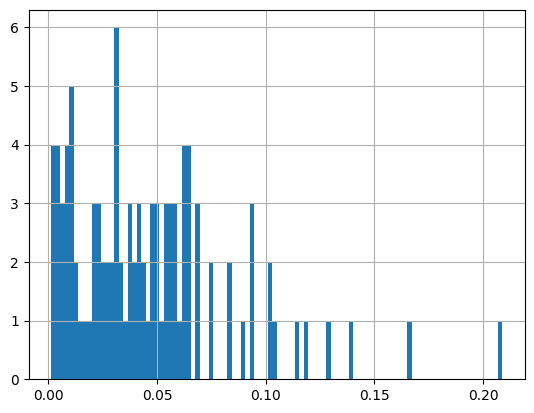

In [102]:
# ErrCube列の値が-1000または0である行を削除する
df_cube = df[(df['ErrCube'] != -1000.0) & (df['ErrCube'] != 0.0)]
df_cube['ErrCube'].hist(bins=100)

In [103]:
df_cube['ErrCube'].describe()

count    102.000000
mean       0.046470
std        0.036910
min        0.001351
25%        0.020844
50%        0.040979
75%        0.063059
max        0.208665
Name: ErrCube, dtype: float64

<Axes: >

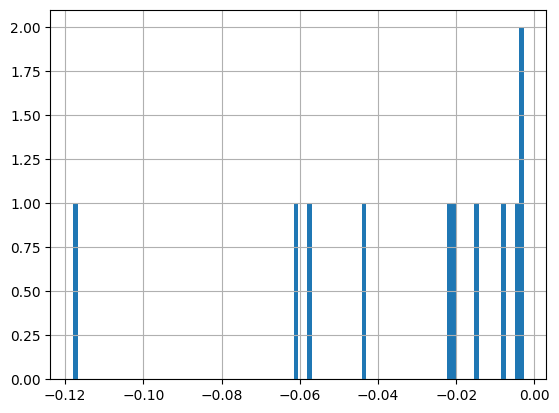

In [104]:
# ErrCube列の値が-1000または0である行を削除する
df_take = df[(df['ErrTake'] != -1000.0) & (df['ErrTake'] != 0.0)]
df_take['ErrTake'].hist(bins=100)

In [105]:
df_take['ErrTake'].describe()

count    11.000000
mean     -0.032292
std       0.035397
min      -0.117985
25%      -0.050248
50%      -0.020435
75%      -0.006305
max      -0.002684
Name: ErrTake, dtype: float64

In [106]:
df.to_pickle('data/xg_data.pkl')

In [107]:
df = pd.read_pickle('data/xg_data.pkl')

In [108]:
pd.crosstab(df['CubeB'], df['ActiveP'])

ActiveP,-1,1
CubeB,,
-3,2,0
-2,13,0
-1,128,0
0,590,518
1,0,126
2,0,7


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1384 entries, 5 to 12469
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    1384 non-null   object 
 1   EntryType               1384 non-null   int64  
 2   ActiveP                 1384 non-null   int64  
 3   Double                  1384 non-null   int64  
 4   Take                    1384 non-null   int64  
 5   BeaverR                 1384 non-null   int64  
 6   RaccoonR                1384 non-null   int64  
 7   CubeB                   1384 non-null   int64  
 8   Position                1384 non-null   object 
 9   Doubled_Pos             1384 non-null   object 
 10  Doubled_Level           1384 non-null   int64  
 11  Doubled_Score           1384 non-null   object 
 12  Doubled_Cube            1384 non-null   int64  
 13  Doubled_CubePos         1384 non-null   int64  
 14  Doubled_Jacoby          1384 non-null   int6